# Predictive Modelling: RandomForest

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

# Pandas and numpy
import pandas as pd
import numpy as np

# 
from IPython.display import display, clear_output
import sys
import time

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from src.visualization.visualize import plot_corr_matrix, plot_multi, plot_norm_dist, plot_feature_importances

# Some custom tools
from src.data.tools import check_for_missing_vals

# 
from src.models.predict_model import avg_model, run_combinations
#from src.models.train_model import run_combinations 

# Alpaca API
import alpaca_trade_api as tradeapi

# Pickle
import pickle
import os
from pathlib import Path

# To load variables from .env file into system environment
from dotenv import find_dotenv, load_dotenv

from atomm.Indicators import MomentumIndicators
from atomm.DataManager.main import MSDataManager
from atomm.Tools import calc_open_position, calc_returns
from src.visualization.visualize import plot_confusion_matrix
from atomm.Methods import BlockingTimeSeriesSplit, PurgedKFold           


import time

# scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit

from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# For BayesianHyperparameter Optimization
from atomm.Models.Tuning import search_space, BayesianSearch
from hyperopt import space_eval

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import matplotlib.gridspec as gridspec
#import matplotlib.style as style
from scipy import stats

In [2]:
# Load environment variables
load_dotenv(find_dotenv())

True

## Loading the data

In [3]:
data_base_dir = os.environ.get('DATA_DIR_BASE_PATH')

fname = os.path.join(data_base_dir, 'processed', 'index.h5')
fname = Path(fname)
# Load dataset from HDF storage
with pd.HDFStore(fname) as storage:
    djia = storage.get('nyse/cleaned/rand_symbols')
    y_2c = storage.get('nyse/engineered/target_two_class')
    y_3c = storage.get('nyse/engineered/target_three_class')
    df_moments = storage.get('nyse/engineered/features')
    #print(storage.info())
    
# Create copies of the pristine data
X = df_moments.copy()
y = y_3c.copy()
y2 = y_2c.copy()
prices = djia.copy()

In [4]:
forecast_horizon = [1, 3, 5, 7, 10, 15, 20, 25, 30]
input_window_size = [3, 5, 7, 10, 15, 20, 25, 30]
ti_list = ['macd', 'rsi', 'stoc', 'roc', 'bbu', 'bbl', 'ema', 'atr', 'adx', 'cci', 'williamsr', 'stocd']
symbol_list = df_moments.columns.get_level_values(0).unique()

In [5]:
df_moments.columns.get_level_values(1).unique()

Index(['macd_3', 'rsi_3', 'stoc_3', 'roc_3', 'bbu_3', 'bbl_3', 'ema_3',
       'atr_3', 'adx_3', 'cci_3', 'williamsr_3', 'stocd_3', 'macd_5', 'rsi_5',
       'stoc_5', 'roc_5', 'bbu_5', 'bbl_5', 'ema_5', 'atr_5', 'adx_5', 'cci_5',
       'williamsr_5', 'stocd_5', 'macd_7', 'rsi_7', 'stoc_7', 'roc_7', 'bbu_7',
       'bbl_7', 'ema_7', 'atr_7', 'adx_7', 'cci_7', 'williamsr_7', 'stocd_7',
       'macd_10', 'rsi_10', 'stoc_10', 'roc_10', 'bbu_10', 'bbl_10', 'ema_10',
       'atr_10', 'adx_10', 'cci_10', 'williamsr_10', 'stocd_10', 'macd_15',
       'rsi_15', 'stoc_15', 'roc_15', 'bbu_15', 'bbl_15', 'ema_15', 'atr_15',
       'adx_15', 'cci_15', 'williamsr_15', 'stocd_15', 'macd_20', 'rsi_20',
       'stoc_20', 'roc_20', 'bbu_20', 'bbl_20', 'ema_20', 'atr_20', 'adx_20',
       'cci_20', 'williamsr_20', 'stocd_20', 'macd_25', 'rsi_25', 'stoc_25',
       'roc_25', 'bbu_25', 'bbl_25', 'ema_25', 'atr_25', 'adx_25', 'cci_25',
       'williamsr_25', 'stocd_25', 'macd_30', 'rsi_30', 'stoc_30', 'ro

## Imputing missing values

In [6]:
X.shape

(1954, 4800)

In [7]:
check_for_missing_vals(X)

No missing values found in dataframe


Prices values

In [8]:
prices.shape

(1954, 250)

In [9]:
check_for_missing_vals(prices)

No missing values found in dataframe


In [10]:
y_3c.shape

(1954, 450)

In [11]:
check_for_missing_vals(y_3c)

No missing values found in dataframe


In [12]:
y2.shape

(1954, 450)

In [13]:
check_for_missing_vals(y2)

No missing values found in dataframe


No missing values, and sizes of ```y.shape[0]``` and```X.shape[0]``` match.

# Scaling the features

In [14]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [15]:
#scale = MinMaxScaler()
scale = StandardScaler()

In [16]:
scaled = scale.fit_transform(X)

In [17]:
scaled.shape

(1954, 4800)

In [18]:
#X_scaled = pd.DataFrame(data=scaled, columns=X.columns)
X_scaled = X

# Train-Test Split

In [19]:
# Use 70/30 train/test splits
test_p = .3

In [30]:
# Three-class
test_size = int((1 - test_p) * X_scaled.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y_3c[:test_size], y_3c[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [22]:
# Unscaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X[:test_size], X[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [58]:
# Scaled, two-class
test_size = int((1 - test_p) * X.shape[0])
X_train, X_test, y_train, y_test = X_scaled[:test_size], X_scaled[test_size:], y2[:test_size], y2[test_size:]
prices_train, prices_test = djia[:test_size], djia[test_size:]

In [ ]:
#test_size = test_p
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_3c, test_size=test_size, random_state=101)

# Model

In [23]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [22]:
symbol = 'T'
n1 = 15
n2 = 15
n_estimators = 10
# set up cross validation splits
tscv = TimeSeriesSplit(n_splits=5)
btscv = BlockingTimeSeriesSplit(n_splits=5)
#ppcv = PurgedKFold(n_splits=5)

In [67]:
# Creates a list of features for a given lookback window (n1)
features = [f'{x}_{n1}' for x in ti_list]
# Creates a list of all features
all_features = [f'{x}_{n}' for x in ti_list for n in input_window_size]

## Single lookback/lookahead combination

In [102]:
clf_svc1 = OneVsRestClassifier(
    BaggingClassifier(
                    SVC(
                        kernel='rbf',
                        class_weight='balanced'
                    ),
                    max_samples=.4, 
                    n_estimators=n_estimators,
                    n_jobs=-1)
)


clf_svc1.fit(X_train[symbol][[f'{x}_{n}' for x in ti_list]], y_train[symbol][f'signal_{n}'])

OneVsRestClassifier(estimator=BaggingClassifier(base_estimator=SVC(C=1.0,
                                                                   break_ties=False,
                                                                   cache_size=200,
                                                                   class_weight='balanced',
                                                                   coef0=0.0,
                                                                   decision_function_shape='ovr',
                                                                   degree=3,
                                                                   gamma='scale',
                                                                   kernel='rbf',
                                                                   max_iter=-1,
                                                                   probability=False,
                                                                   random_state=None

Accuracy Score:  0.5400340715502555
              precision    recall  f1-score   support

           0       0.91      0.52      0.66       505
           1       0.19      0.68      0.29        82

    accuracy                           0.54       587
   macro avg       0.55      0.60      0.48       587
weighted avg       0.81      0.54      0.61       587



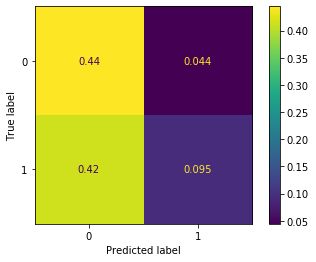

In [103]:
y_pred_svc1 = clf_svc1.predict(X_test[symbol][[f'{x}_{n}' for x in ti_list]])
print('Accuracy Score: ', accuracy_score(y_pred_svc1, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_svc1, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_svc1,
    X_test[symbol][[f'{x}_{n}' for x in ti_list]],
    y_test[symbol][f'signal_{n}'],
    normalize='all'
)

## Averaging across all 50 randomly selected stocks

In [172]:
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,                                  
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_svc1,
    silent = False
)

'Leg [50/50]; Elapsed Time 337.0s\n'

,3,5,7,10,15,20,25,30
1,0.413629,0.41339,0.411721,0.412368,0.409506,0.413663,0.414037,0.412129
3,0.406065,0.406814,0.409165,0.407836,0.406951,0.410971,0.411959,0.414514
5,0.402078,0.405486,0.406917,0.405077,0.408893,0.407939,0.406337,0.408382
7,0.40644,0.406746,0.40586,0.402351,0.406678,0.40954,0.406303,0.413799
10,0.407836,0.407359,0.407019,0.40385,0.408041,0.409915,0.408825,0.405451
15,0.402589,0.408484,0.400818,0.402249,0.405554,0.406269,0.39816,0.397683
20,0.396491,0.398705,0.398637,0.394719,0.397922,0.397002,0.39925,0.396559
25,0.397615,0.394617,0.398126,0.396934,0.400443,0.401193,0.399761,0.396899
30,0.396048,0.394991,0.395707,0.392811,0.397683,0.406269,0.401704,0.398535


## Hyperparamter Optimization: GridSearch

In [163]:
gsearch_xgb.best_score_

0.5876651982378854

## Hyperparamter Optimization: Bayesian Optimization

### RF with fixed single lookback horizon

In [44]:
n1=15
n2=15
symbol='T'

In [25]:
y_train[symbol][f'signal_{n2}'].value_counts()

1    724
0    643
Name: signal_15, dtype: int64

In [26]:
symbol_list

Index(['CNC', 'FMC', 'ALGN', 'RTN', 'FAST', 'ETFC', 'ABC', 'PFG', 'AXP', 'PNW',
       'CMS', 'URI', 'PRGO', 'DRI', 'MAS', 'M', 'ZION', 'CINF', 'HIG', 'EOG',
       'ICE', 'CBOE', 'ALL', 'UHS', 'FRT', 'NEM', 'BLL', 'NDAQ', 'CMG', 'JKHY',
       'T', 'QCOM', 'FTI', 'AOS', 'ATVI', 'STT', 'TXN', 'KIM', 'NTAP', 'CHD',
       'WYNN', 'GM', 'SJM', 'MCHP', 'ES', 'KMB', 'GIS', 'EXC', 'IBM', 'MSFT'],
      dtype='object')

In [42]:
# Optimizing for accuracy_score

In [45]:
model = RandomForestClassifier
bsearch_rfa, clf_bsearch_rfa, params_bsearch_rfa = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='accuracy_score'
)

100%|██████████| 100/100 [04:20<00:00,  2.61s/it, best loss: -0.6181818181818182]
##### Results #####
Score best parameters:  -0.6181818181818182
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 85, 'max_features': 1, 'min_samples_leaf': 17, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 359, 'n_jobs': -1}
Test Score (accuracy):  0.5775127768313458
Parameter combinations evaluated:  100
Time elapsed:  261.2132532596588


Recall Score:  0.5827505827505828
              precision    recall  f1-score   support

           0       0.33      0.56      0.42       158
           1       0.78      0.58      0.67       429

    accuracy                           0.58       587
   macro avg       0.56      0.57      0.54       587
weighted avg       0.66      0.58      0.60       587



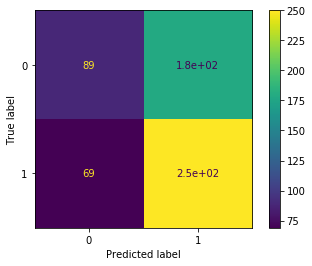

In [46]:
y_pred_bsearch_rfa = clf_bsearch_rfa.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_rfa, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_rfa, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_rfa,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
    
)

In [65]:
calc_returns(y_pred_bsearch_rfa, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,1,-0.010550,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,-0.008064,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,-0.005585,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.105152,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.117103,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.115563,0.115563


In [ ]:
# Recall as scoring metric

In [48]:
model = RandomForestClassifier
bsearch_rfb, clf_bsearch_rfb, params_bsearch_rfb = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='recall_score'
)

100%|██████████| 100/100 [03:58<00:00,  2.38s/it, best loss: -0.9049689440993788]
##### Results #####
Score best parameters:  -0.9049689440993788
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 106, 'max_features': 'auto', 'min_samples_leaf': 13, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 199, 'n_jobs': -1}
Test Score (accuracy):  0.5877342419080068
Parameter combinations evaluated:  100
Time elapsed:  239.02671217918396


Recall Score:  0.5914489311163895
              precision    recall  f1-score   support

           0       0.36      0.58      0.44       166
           1       0.78      0.59      0.67       421

    accuracy                           0.59       587
   macro avg       0.57      0.58      0.56       587
weighted avg       0.66      0.59      0.61       587



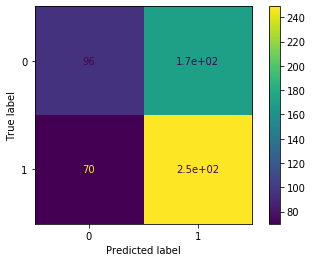

In [51]:
y_pred_bsearch_rfb = clf_bsearch_rfb.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_rfb, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_rfb, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_rfb,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
    
)

In [64]:
calc_returns(y_pred_bsearch_rfb, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.115264,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.127215,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.125675,0.115563


In [52]:
# Precision as scoring metric

In [53]:
model = RandomForestClassifier
bsearch_rfc, clf_bsearch_rfc, params_bsearch_rfc = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='precision_score'
)

100%|██████████| 100/100 [05:02<00:00,  3.02s/it, best loss: -0.6067194209299471]
##### Results #####
Score best parameters:  -0.6067194209299471
Best parameters:  {'bootstrap': False, 'criterion': 'entropy', 'cv': 'btscv', 'max_depth': 1, 'max_features': 5, 'min_samples_leaf': 19, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 419, 'n_jobs': -1}
Test Score (accuracy):  0.5809199318568995
Parameter combinations evaluated:  100
Time elapsed:  302.94145035743713


Recall Score:  0.6016713091922006
              precision    recall  f1-score   support

           0       0.47      0.55      0.50       228
           1       0.68      0.60      0.64       359

    accuracy                           0.58       587
   macro avg       0.57      0.57      0.57       587
weighted avg       0.60      0.58      0.59       587



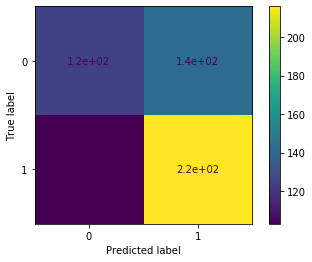

In [57]:
y_pred_bsearch_rfc = clf_bsearch_rfc.predict(X_test[symbol][features])
print('Precision Score: ', precision_score(y_pred_bsearch_rfc, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_rfc, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_rfc,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}']
)


In [63]:
calc_returns(y_pred_bsearch_rfc, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.119024,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.130975,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.129435,0.115563


In [ ]:
# Checking next day forecast

In [126]:
n2=15
n1=15
features2 = [f'{x}_{n1}' for x in ti_list]
model = RandomForestClassifier
bsearch_rfc_1, clf_bsearch_rfc_1, params_bsearch_rfc_1 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features2], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features2],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='precision_score'
)

100%|██████████| 100/100 [04:47<00:00,  2.88s/it, best loss: -0.5989842973563904]
##### Results #####
Score best parameters:  -0.5989842973563904
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 13, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 318, 'n_jobs': -1}
Test Score (accuracy):  0.5792163543441227
Parameter combinations evaluated:  100
Time elapsed:  288.7594609260559


In [127]:
y_pred_bsearch_rfc_1 = clf_bsearch_rfc_1.predict(X_test[symbol][features2])
calc_returns(y_pred_bsearch_rfc_1, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.117951,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.117951,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.117951,0.115563


In [58]:
# F1 score as scoring metric

In [59]:
model = RandomForestClassifier
bsearch_rfd, clf_bsearch_rfd, params_bsearch_rfd = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][features], 
    y_train[symbol][f'signal_{n2}'], 
    X_test[symbol][features],
    y_test[symbol][f'signal_{n2}'],
    num_eval=100,
    scoring_metric='f1_score'
)

100%|██████████| 100/100 [03:48<00:00,  2.29s/it, best loss: -0.695135189669088]
##### Results #####
Score best parameters:  -0.695135189669088
Best parameters:  {'bootstrap': False, 'criterion': 'entropy', 'cv': 'btscv', 'max_depth': 107, 'max_features': 'auto', 'min_samples_leaf': 14, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 141, 'n_jobs': -1}
Test Score (accuracy):  0.5911413969335605
Parameter combinations evaluated:  100
Time elapsed:  229.31292700767517


Recall Score:  0.5965770171149144
              precision    recall  f1-score   support

           0       0.38      0.58      0.46       178
           1       0.76      0.60      0.67       409

    accuracy                           0.59       587
   macro avg       0.57      0.59      0.57       587
weighted avg       0.65      0.59      0.61       587



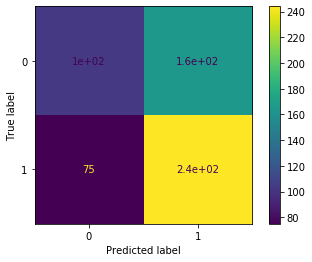

In [60]:
y_pred_bsearch_rfd = clf_bsearch_rfd.predict(X_test[symbol][features])
print('Recall Score: ', recall_score(y_pred_bsearch_rfd, y_test[symbol][f'signal_{n2}']))
print(classification_report(y_pred_bsearch_rfd, y_test[symbol][f'signal_{n2}']))
plot_confusion_matrix(
    clf_bsearch_rfd,
    X_test[symbol][features], y_test[symbol][f'signal_{n2}'],
)

In [62]:
calc_returns(y_pred_bsearch_rfd, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,1,0.115264,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.127215,0.117103
2019-11-04 00:00:00+00:00,-0.001540,1,0.125675,0.115563


In [ ]:
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(  
    symbol_list[:2],
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_rf4,
    silent = False
)

### RF with all features as lookback horizon

In [66]:
# Accuracy as scoring metric

In [66]:
n=15
symbol='T'

model = RandomForestClassifier
bsearch_rf1, clf_rf1, params_rf1 = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='accuracy_score'
)

100%|██████████| 100/100 [04:37<00:00,  2.77s/it, best loss: -0.6290909090909091]
##### Results #####
Score best parameters:  -0.6290909090909091
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 187, 'max_features': 1, 'min_samples_leaf': 6, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 8, 'n_jobs': -1}
Test Score (accuracy):  0.575809199318569
Parameter combinations evaluated:  100
Time elapsed:  277.6425049304962


Accuracy Score:  0.575809199318569
              precision    recall  f1-score   support

           0       0.27      0.57      0.37       127
           1       0.83      0.58      0.68       460

    accuracy                           0.58       587
   macro avg       0.55      0.58      0.52       587
weighted avg       0.71      0.58      0.61       587



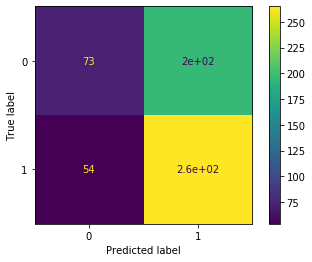

In [68]:
y_pred_rf1 = clf_rf1.predict(X_test[symbol][all_features])
print('Accuracy Score: ', accuracy_score(y_pred_rf1, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf1, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf1,
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'],
)

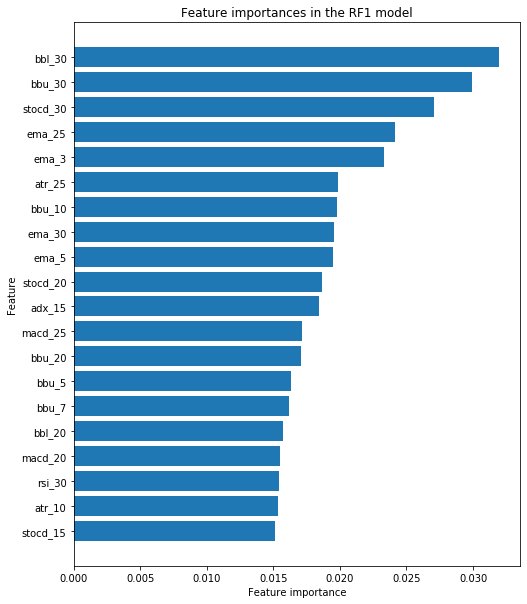

In [73]:

plot_feature_importances(clf_rf1.feature_importances_, all_features, 'RF1', top_count=20)


In [89]:
calc_returns(y_pred_rf1, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,1,0.006284,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.006284,-0.010550
2017-07-14 00:00:00+00:00,0.002486,1,0.008770,-0.008064
2017-07-17 00:00:00+00:00,0.002479,1,0.011249,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.100148,0.105152
2019-11-01 00:00:00+00:00,0.011951,1,0.112099,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.112099,0.115563


In [ ]:
# Recall as scoring metric

In [85]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf2, clf_rf2, params_rf2  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='recall_score'
)

100%|██████████| 100/100 [05:04<00:00,  3.05s/it, best loss: -0.9357142857142857]
##### Results #####
Score best parameters:  -0.9357142857142857
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 1, 'max_features': 4, 'min_samples_leaf': 19, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 291, 'n_jobs': -1}
Test Score (accuracy):  0.58603066439523
Parameter combinations evaluated:  100
Time elapsed:  305.3799817562103


Recall Score:  0.6032608695652174
              precision    recall  f1-score   support

           0       0.46      0.56      0.50       219
           1       0.70      0.60      0.65       368

    accuracy                           0.59       587
   macro avg       0.58      0.58      0.57       587
weighted avg       0.61      0.59      0.59       587



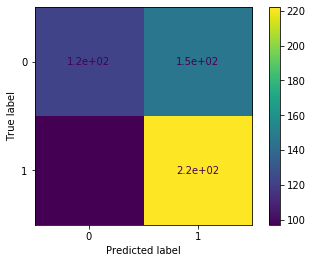

In [86]:
y_pred_rf2 = clf_rf2.predict(X_test[symbol][all_features])
print('Recall Score: ', recall_score(y_pred_rf2, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf2, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(clf_rf2, X_test[symbol][all_features], y_test[symbol][f'signal_{n}'])


In [90]:
calc_returns(y_pred_rf2, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.00000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.00000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.00000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.00000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,-0.05502,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,-0.05502,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,-0.05502,0.115563


In [77]:
# f1_score as scoring metric

In [78]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf3, clf_rf3, params_rf3  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'],
    num_eval=100,
    scoring_metric='f1_score'
)

100%|██████████| 100/100 [05:22<00:00,  3.23s/it, best loss: -0.7138722691932529]
##### Results #####
Score best parameters:  -0.7138722691932529
Best parameters:  {'bootstrap': False, 'criterion': 'gini', 'cv': 'btscv', 'max_depth': 1, 'max_features': 'auto', 'min_samples_leaf': 15, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 405, 'n_jobs': -1}
Test Score (accuracy):  0.5826235093696763
Parameter combinations evaluated:  100
Time elapsed:  323.5298318862915


F1 Score:  0.6423357664233577
              precision    recall  f1-score   support

           0       0.46      0.55      0.50       221
           1       0.69      0.60      0.64       366

    accuracy                           0.58       587
   macro avg       0.57      0.58      0.57       587
weighted avg       0.60      0.58      0.59       587



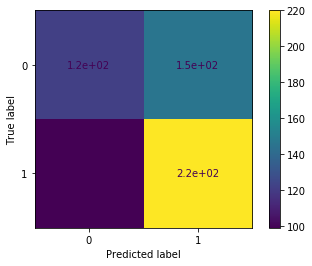

In [79]:
y_pred_rf3 = clf_rf3.predict(X_test[symbol][all_features])
print('F1 Score: ', f1_score(y_pred_rf3, y_test[symbol][f'signal_{n}']))
print(classification_report(y_pred_rf3, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf3, X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'])



In [91]:
calc_returns(y_pred_rf3, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,-0.129969,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,-0.129969,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,-0.129969,0.115563


In [81]:
# precision_score as scoring metric

In [158]:
n=15
symbol='T'

model = RandomForestClassifier
RandomForestClassifier()
bsearch_rf4, clf_rf4, params_rf4  = BayesianSearch(
    search_space(model),
    model,
    X_train[symbol][all_features], 
    y_train[symbol][f'signal_{n}'], 
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}'],
    num_eval=10,
    scoring_metric='precision_score'
)

100%|██████████| 10/10 [00:34<00:00,  3.45s/it, best loss: -0.6242940685045948]
##### Results #####
Score best parameters:  -0.6242940685045948
Best parameters:  {'bootstrap': False, 'criterion': 'entropy', 'cv': 'btscv', 'max_depth': 280, 'max_features': 'auto', 'min_samples_leaf': 1, 'model': <class 'sklearn.ensemble._forest.RandomForestClassifier'>, 'n_estimators': 338, 'n_jobs': -1}
Test Score (accuracy):  0.596252129471891
Parameter combinations evaluated:  10
Time elapsed:  37.19841003417969


Precision Score:  0.7091791008907974
              precision    recall  f1-score   support

           0       0.30      0.60      0.40       135
           1       0.83      0.59      0.69       452

    accuracy                           0.59       587
   macro avg       0.57      0.59      0.54       587
weighted avg       0.71      0.59      0.62       587



array([[ 81, 187],
       [ 54, 265]])

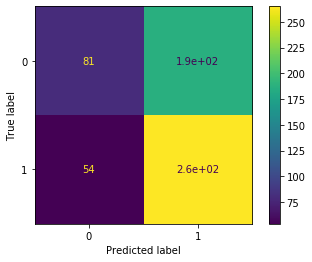

In [147]:
y_pred_rf4 = clf_rf4.predict(X_test[symbol][all_features])
print('Precision Score: ', precision_score(y_pred_rf4, y_test[symbol][f'signal_{n}'], average='weighted'))
print(classification_report(y_pred_rf4, y_test[symbol][f'signal_{n}']))
plot_confusion_matrix(
    clf_rf4,
    X_test[symbol][all_features],
    y_test[symbol][f'signal_{n}']
)
confusion_matrix(y_test[symbol][f'signal_{n}'], y_pred_rf4)


In [148]:
calc_returns(y_pred_rf4, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,0,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.000000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.000000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.000000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.000000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.119276,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.119276,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.119276,0.115563


In [98]:
calc_returns(y_pred_rf4, djia[symbol][test_size:])

,Close,Signal_Strat,Cum_Returns_Strat,Cum_Returns_BH
Epoch,,,,
2017-07-11 00:00:00+00:00,NaN,1,NaN,NaN
2017-07-12 00:00:00+00:00,0.006284,0,0.00000,0.006284
2017-07-13 00:00:00+00:00,-0.016834,0,0.00000,-0.010550
2017-07-14 00:00:00+00:00,0.002486,0,0.00000,-0.008064
2017-07-17 00:00:00+00:00,0.002479,0,0.00000,-0.005585
...,...,...,...,...
2019-10-31 00:00:00+00:00,0.007592,0,0.18421,0.105152
2019-11-01 00:00:00+00:00,0.011951,0,0.18421,0.117103
2019-11-04 00:00:00+00:00,-0.001540,0,0.18421,0.115563


In [ ]:
['stoc_3', 'atr_3', 'williamsr_3', 'cci_3', 'rsi_3', 'adx_3', 'macd_3', 'roc_3', 'ema_3', 'bbu_3', 'stocd_3', 'stoc_5', 'atr_5', 'williamsr_5', 'cci_5', 'rsi_5', 'adx_5', 'macd_5', 'roc_5', 'ema_5', 'bbu_5', 'stocd_5', 'stoc_7', 'atr_7', 'williamsr_7', 'cci_7', 'rsi_7', 'adx_7', 'macd_7', 'roc_7', 'ema_7', 'bbu_7', 'stocd_7', 'stoc_10', 'atr_10', 'williamsr_10', 'cci_10', 'rsi_10', 'adx_10', 'macd_10', 'roc_10', 'ema_10', 'bbu_10', 'stocd_10', 'stoc_15', 'atr_15', 'williamsr_15', 'cci_15', 'rsi_15', 'adx_15', 'macd_15', 'roc_15', 'ema_15', 'bbu_15', 'stocd_15', 'stoc_20', 'atr_20', 'williamsr_20', 'cci_20', 'rsi_20', 'adx_20', 'macd_20', 'roc_20', 'ema_20', 'bbu_20', 'stocd_20', 'stoc_25', 'atr_25', 'williamsr_25', 'cci_25', 'rsi_25', 'adx_25', 'macd_25', 'roc_25', 'ema_25', 'bbu_25', 'stocd_25', 'stoc_30', 'atr_30', 'williamsr_30', 'cci_30', 'rsi_30', 'adx_30', 'macd_30', 'roc_30', 'ema_30', 'bbu_30', 'stocd_30'],

In [155]:
X_test.index

DatetimeIndex(['2017-07-11 00:00:00+00:00', '2017-07-12 00:00:00+00:00',
               '2017-07-13 00:00:00+00:00', '2017-07-14 00:00:00+00:00',
               '2017-07-17 00:00:00+00:00', '2017-07-18 00:00:00+00:00',
               '2017-07-19 00:00:00+00:00', '2017-07-20 00:00:00+00:00',
               '2017-07-21 00:00:00+00:00', '2017-07-24 00:00:00+00:00',
               ...
               '2019-10-24 00:00:00+00:00', '2019-10-25 00:00:00+00:00',
               '2019-10-28 00:00:00+00:00', '2019-10-29 00:00:00+00:00',
               '2019-10-30 00:00:00+00:00', '2019-10-31 00:00:00+00:00',
               '2019-11-01 00:00:00+00:00', '2019-11-04 00:00:00+00:00',
               '2019-11-05 00:00:00+00:00', '2019-11-06 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Epoch', length=587, freq=None)

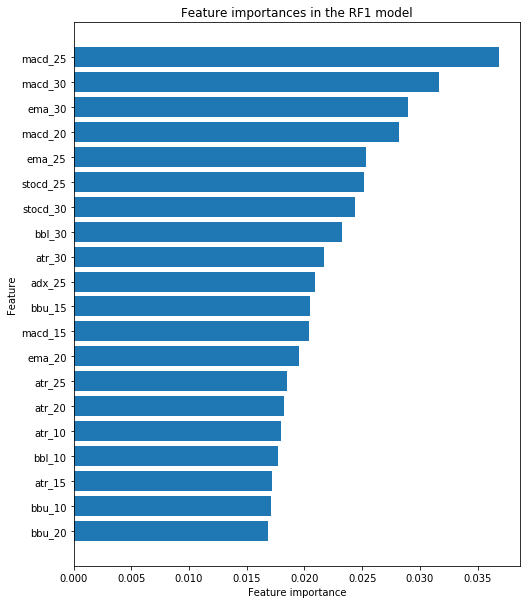

In [131]:
plot_feature_importances(clf_rf4.feature_importances_, all_features, 'RF1', top_count=20)


In [102]:
# Permanentely storing the best performing model to hard disk
from joblib import dump, load
clf_rf4
dump(clf_rf4, '/Users/robin/Documents/nf-ds/capstone_nf/models/RF_best.joblib')

['/Users/robin/Documents/nf-ds/capstone_nf/models/RF_best.joblib']

In [153]:
print(str(clf_rf4))

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=228, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=329,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)


#### Running on all 50 stocks on best model

In [110]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(  
    symbol_list[:2],
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=clf_rf4,
    silent = False
)

'Leg [2/2]; Elapsed Time 70.0s\n'

,3,5,7,10,15,20,25,30
1,0.492334,0.488927,0.484668,0.482112,0.494037,0.480409,0.483816,0.48552
3,0.500852,0.483816,0.498296,0.482964,0.48552,0.501704,0.48552,0.473595
5,0.488075,0.534072,0.545997,0.528109,0.521295,0.520443,0.5,0.483816
7,0.501704,0.528961,0.537479,0.527257,0.511925,0.524702,0.508518,0.488075
10,0.502555,0.511925,0.528961,0.53833,0.541738,0.53833,0.503407,0.505111
15,0.492334,0.532368,0.540886,0.500852,0.48552,0.441227,0.460818,0.442078
20,0.520443,0.511925,0.50937,0.498296,0.500852,0.491482,0.478705,0.423339
25,0.467632,0.478705,0.511925,0.519591,0.492334,0.48552,0.453152,0.420784
30,0.51448,0.530664,0.534923,0.544293,0.522147,0.508518,0.460818,0.459966


In [119]:
returns_dict['CNC'].max()

3     0.323974
5     0.040124
7     0.219872
10    0.247853
15    0.142701
20   -0.121261
25   -0.147591
30   -0.406337
dtype: float64

In [118]:
returns_dict['FMC'].max()

3     0.061496
5     0.108737
7     0.024551
10    0.007889
15    0.015822
20   -0.008669
25    0.243224
30    0.012433
dtype: float64

In [ ]:
#best_params = {'bootstrap': False, 'criterion': 'gini', 'max_depth': 218, 'max_features': 1, 'min_samples_leaf': 19, 'n_estimators': 423}
#model_2a = (n_jobs=-1, **params_rf4)
avg_results, scores_dict, preds_dict, params_dict, returns_dict = avg_model(
    symbol_list,
    forecast_horizon,                                 
    input_window_size,
    ti_list,
    X_train,    
    X_test,    
    y_train,    
    y_test,    
    prices_test,
    model=RandomForestClassifier,
    silent = False,
    hyper_optimize=True,
    n_eval=10,
)